In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from numpy import linalg
import copy
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model

In [2]:
market_train_df = pd.read_csv('market_train_df.csv')

In [3]:
market_train_df.head()

,Unnamed: 0,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


# Get industry information

In [4]:
basic = pd.read_csv('./sector/basic industries.csv')['Symbol']
capital = pd.read_csv('./sector/capital_goods.csv')['Symbol']
prod = pd.read_csv('./sector/consumer products.csv')['Symbol']
service = pd.read_csv('./sector/consumer service.csv')['Symbol']
energy = pd.read_csv('./sector/energy.csv')['Symbol']
finance = pd.read_csv('./sector/finance.csv')['Symbol']
healthcare = pd.read_csv('./sector/healthcare.csv')['Symbol']
misc = pd.read_csv('./sector/miscellaneous.csv')['Symbol']
tech = pd.read_csv('./sector/technology.csv')['Symbol']
transport = pd.read_csv('./sector/transportation.csv')['Symbol']
utility = pd.read_csv('./sector/utilities.csv')['Symbol']
sectors = [basic, capital, prod, service, energy, finance, healthcare, misc,
          tech, transport, utility]

#sector name cleaning
for i, sec in enumerate(sectors):
    for j, name in enumerate(sec):
        sectors[i][j] = sectors[i][j].strip()
    sectors[i] = set(sectors[i])

sectorMapping = dict()
num_rows = market_train_df.shape[0]
industry_class = np.zeros(num_rows)
for i in range(num_rows):
    if i % 500000 == 0:
        print ('step ' + str(i//500000) + ' is done')
    name = market_train_df.loc[i, 'assetCode']
    name = name[:name.find('.')] if name.find('.') != -1 else name
    existed = False
    for j, sec in enumerate(sectors):
        if name in sec:
            industry_class[i] = j + 1
            sectorMapping[name] = j + 1
            existed = True
            break
    if existed == False:
        sectorMapping[name] = 0
        
print ('Done')

step 0 is done
step 1 is done
step 2 is done
step 3 is done
step 4 is done
step 5 is done
step 6 is done
step 7 is done
step 8 is done
Done


# Outlier filter

In [5]:
market_train_df = market_train_df[market_train_df['returnsClosePrevRaw1']>-0.4]
market_train_df = market_train_df[market_train_df['returnsClosePrevRaw1']< 0.4]
market_train_df = market_train_df[market_train_df['returnsOpenPrevRaw1']>-0.4]
market_train_df = market_train_df[market_train_df['returnsOpenPrevRaw1']< 0.4]
market_train_df = market_train_df[market_train_df['returnsOpenNextMktres10']>=-1.0]
market_train_df = market_train_df[market_train_df['returnsOpenNextMktres10']<  2.0]

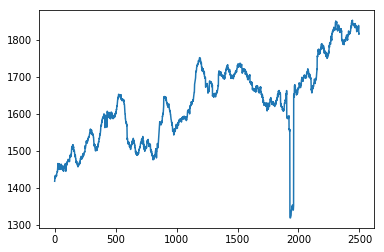

In [6]:
count = 0
count_list = []
curr_date = market_train_df['time'][0]
for date in market_train_df['time']:
    if date == curr_date:
        count+=1
    else:
        count_list.append(count)
        curr_date = date
        count = 1
count_list.append(count)
plt.plot(count_list)

In [222]:
assetCodeSet = set(market_train_df['assetCode'])

In [223]:
len(assetCodeSet)

3780

In [224]:
# Generate a pseudo asset to sector mapping
# Need to be replaced be true asset to sector mapping
assetSectorMap = {}
for asset in assetCodeSet:
    assetSectorMap[asset] = 'sector'+str(random.randint(0,9))

In [280]:
# Use real sector mapping
assetSectorMap = sectorMapping

In [281]:
num_sector = len(set(assetSectorMap.values()))

In [282]:
num_sector

12

(array([1655.,  192.,  117.,  440.,  156.,  293.,  259.,   76.,  304.,
         199.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

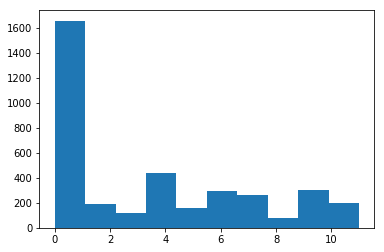

In [283]:
plt.hist(assetSectorMap.values())

In [284]:
sectorCode = [assetSectorMap[asset[:asset.find('.')] if asset.find('.') != -1 else asset] for asset in market_train_df['assetCode']]
#sectorCode = [assetSectorMap[asset] for asset in market_train_df['assetCode']]

In [285]:
market_train_df['sectorCode'] = sectorCode

In [286]:
market_train_df.head()

,Unnamed: 0,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,sectorCode,volumeScaledreturnsOpenPrevRaw10
0,0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0,2,1621.710731
1,1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0,0,-180675.884774
2,2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0,4,52887.176665
3,3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0,9,-882967.904980
4,4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0,0,24651.331445


In [287]:
market_train_df['volumeScaledreturnsOpenPrevRaw10'] = market_train_df['volume']*market_train_df['returnsOpenPrevRaw10']

In [288]:
sumScaledReturns = market_train_df.groupby(['time','sectorCode'])['volumeScaledreturnsOpenPrevRaw10'].sum()

In [289]:
sumVolume = market_train_df.groupby(['time','sectorCode'])['volume'].sum()

In [290]:
weightedSectorReturns = sumScaledReturns/sumVolume

In [291]:
num_sector

12

In [292]:
SectorReturns = {}
for i in range(len(weightedSectorReturns)):
    num_str = '0'+str(i%num_sector) if i%num_sector<10 else str(i%num_sector)
    SectorReturns['sector'+num_str] = SectorReturns.get('sector'+num_str,[])+[weightedSectorReturns.iloc[i]]

In [293]:
SectorReturns = pd.DataFrame(SectorReturns)

In [294]:
SectorReturns.head()

,sector00,sector01,sector02,sector03,sector04,sector05,sector06,sector07,sector08,sector09,sector10,sector11
0,0.026446,0.062050,0.035061,0.026273,-0.002680,0.044343,0.003996,0.014099,0.045442,-0.005009,0.010367,0.033455
1,0.033770,0.071991,0.039359,0.035640,0.006322,0.051470,0.012559,0.012579,0.055731,0.004568,0.013099,0.038446
2,0.042929,0.062558,0.046905,0.035530,-0.000731,0.031303,0.004737,0.011450,0.047899,0.014783,0.009063,0.032372
3,0.046204,0.074940,0.046002,0.033507,0.004508,0.038635,0.011917,0.014356,0.072897,0.022898,0.016558,0.041497
4,0.032597,0.050061,0.045827,0.030412,0.010189,0.017024,0.017839,0.022747,0.070233,0.029531,0.002729,0.026880


# Forecasting correlations

## Correlation structure

In [295]:
totalCorr = SectorReturns.corr()

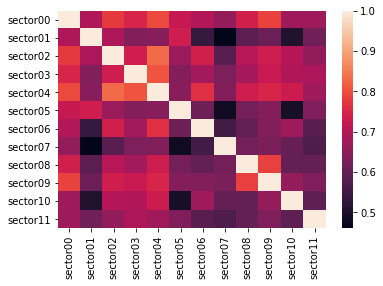

In [296]:
sns.heatmap(totalCorr)

In [297]:
totaleigval = linalg.eig(totalCorr)[0]
totaleigval.sort()
totaleigval

array([0.13830231, 0.18072712, 0.19832582, 0.22025088, 0.26112492,
       0.27655492, 0.33415794, 0.36544331, 0.45448672, 0.52570435,
       0.7316779 , 8.3132438 ])

In [298]:
# Choose a time window to calculate correlation matrix
# Notice the window length should be the same as that for variance calculation
CorrMatRoll = SectorReturns.rolling(20).corr().dropna()

In [299]:
# Apply Ledoit-Wolf shrinkage
shrinkage_factor = 0.2
CorrMatRoll = (1-shrinkage_factor)*CorrMatRoll + shrinkage_factor*np.array(list(np.identity(num_sector))*(len(CorrMatRoll)//num_sector))

In [300]:
# Eigenvalue demonstrate the structure of correlation matrix
ordered_eigenvalues = {}
eigenvalue_series = []
fnorm_deviation_initial = []
fnorm_deviation_previous = []
for i in range(0,len(CorrMatRoll),num_sector):
    window = CorrMatRoll.iloc[i:(i+num_sector),]
    fnorm_deviation_initial.append(linalg.norm(window.reset_index(drop=True)-CorrMatRoll.iloc[:num_sector,].reset_index(drop=True)))
    if i>0:
        fnorm_deviation_previous.append(linalg.norm(window.reset_index(drop=True)-prev_window.reset_index(drop=True)))
    Corr = window.corr()
    eigval = linalg.eig(Corr)[0]
    eigval.sort()
    eigenvalue_series.append(eigval)
    for j in range(num_sector):
        ordered_eigenvalues[j] = ordered_eigenvalues.get(j,[])+[eigval[j]]
    prev_window = window

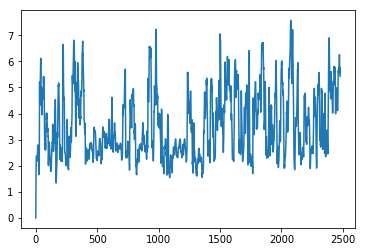

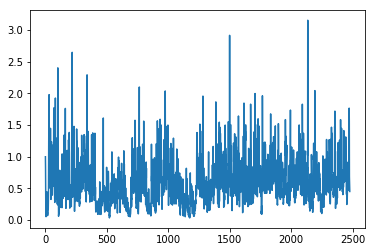

In [301]:
plt.plot(fnorm_deviation_initial)
plt.show()
plt.plot(fnorm_deviation_previous)
plt.show()

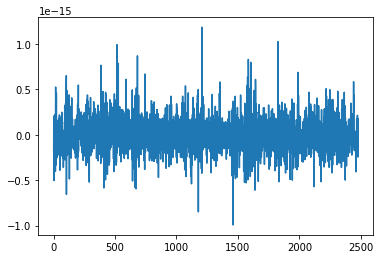

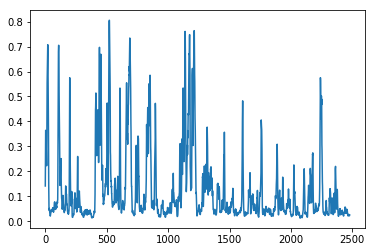

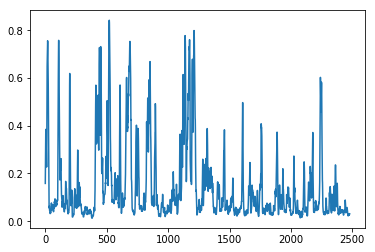

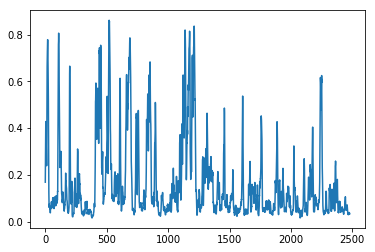

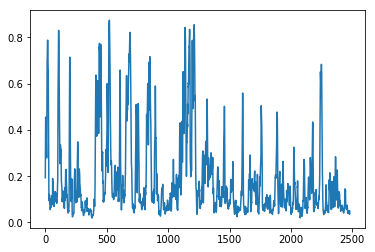

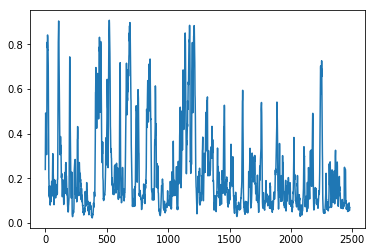

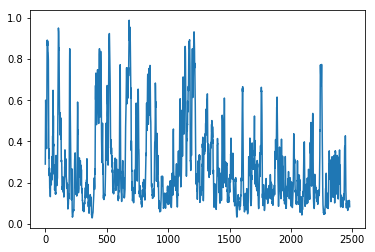

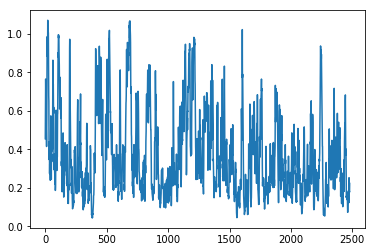

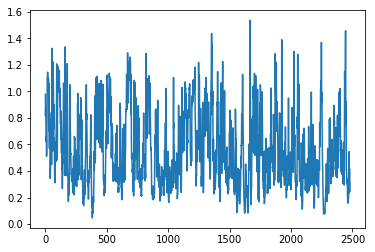

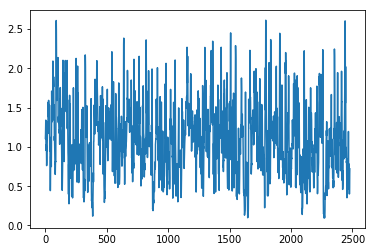

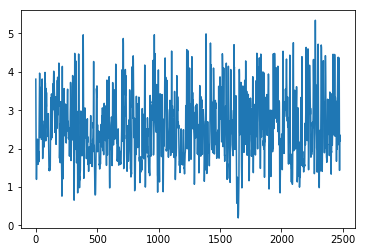

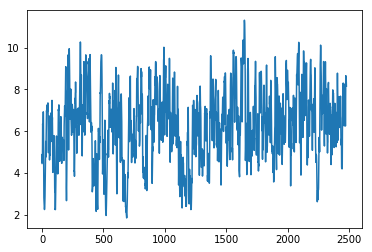

In [302]:
for i in range(num_sector):
    plt.plot(ordered_eigenvalues[i])
    plt.show()

## The condition number is generally very large
## Need some shrinkage

C:\Users\georg\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


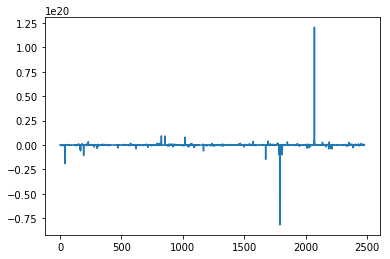

In [303]:
condition_number = [i/j for i,j in zip(ordered_eigenvalues[num_sector-1],ordered_eigenvalues[0])]
plt.plot(condition_number)
plt.show()

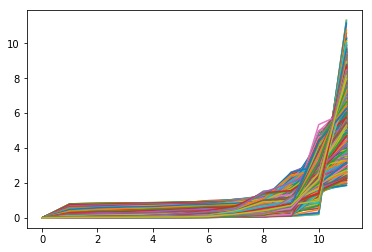

In [304]:
for series in eigenvalue_series:
    plt.plot(series)
plt.show()

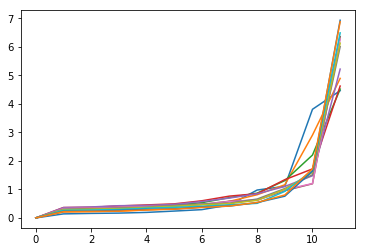

In [305]:
for series in eigenvalue_series[:num_sector]:
    plt.plot(series)
plt.show()

## Correlation forecasting using EWMA

In [306]:
CorrMatRoll.shape

(29748, 12)

In [307]:
CorrMatRoll

sector00  sector01  sector02  sector03  sector04  sector05  \
19   sector00  1.000000  0.655911  0.617334  0.721961  0.559112  0.422984   
     sector01  0.655911  1.000000  0.560768  0.695516  0.403370  0.667080   
     sector02  0.617334  0.560768  1.000000  0.702058  0.675536  0.395730   
     sector03  0.721961  0.695516  0.702058  1.000000  0.600857  0.469333   
     sector04  0.559112  0.403370  0.675536  0.600857  1.000000  0.204100   
     sector05  0.422984  0.667080  0.395730  0.469333  0.204100  1.000000   
     sector06  0.627760  0.555209  0.726715  0.737271  0.694048  0.323345   
     sector07  0.564490  0.608526  0.743794  0.695902  0.591560  0.526438   
     sector08  0.555616  0.635486  0.607166  0.581215  0.381345  0.505784   
     sector09  0.597406  0.515104  0.570806  0.589203  0.635635  0.290935   
     sector10  0.379230  0.378123  0.376120  0.426269  0.516224  0.232791   
     sector11  0.701373  0.718220  0.697146  0.758120  0.589819  0.572876   
20   sector00  1.000000  0.713044  0.673877  0.747789  0.641839  0.479789   
     sector01  0.713044  1.000000  0.625340  0.726519  0.551673  0.651530   
     sector02  0.673877  0.625340  1.000000  0.728173  0.725786  0.431963   
     sector03  0.747789  0.726519  0.728173  1.000000  0.674208  0.495660   
     sector04  0.641839  0.551673  0.725786  0.674208  1.000000  0.324368   
     sector05  0.479789  0.651530  0.431963  0.495660  0.324368  1.000000   
     sector06  0.682307  0.635520  0.749714  0.757335  0.733302  0.388970   
     sector07  0.649592  0.657497  0.760665  0.725678  0.686396  0.524035   
     sector08  0.629861  0.669378  0.654972  0.634008  0.521524  0.511978   
     sector09  0.679870  0.662588  0.672022  0.685518  0.696090  0.434552   
     sector10  0.515191  0.519774  0.508789  0.543660  0.610581  0.332305   
     sector11  0.742727  0.738565  0.727541  0.770295  0.683928  0.566009   
21   sector00  1.000000  0.754315  0.718839  0.765534  0.710702  0.579262   
     sector01  0.754315  1.000000  0.689125  0.751239  0.658264  0.671629   
     sector02  0.718839  0.689125  1.000000  0.752814  0.753265  0.529909   
     sector03  0.765534  0.751239  0.752814  1.000000  0.724396  0.561117   
     sector04  0.710702  0.658264  0.753265  0.724396  1.000000  0.474937   
     sector05  0.579262  0.671629  0.529909  0.561117  0.474937  1.000000   
...                 ...       ...       ...       ...       ...       ...   
2495 sector06  0.548614  0.589727  0.765159  0.280577 -0.214863  0.650324   
     sector07 -0.008820 -0.521132 -0.317535  0.448520  0.192790 -0.470713   
     sector08  0.237771 -0.310303 -0.005553  0.686177  0.226737 -0.221483   
     sector09  0.068946 -0.281577 -0.085447  0.566132  0.125906 -0.275831   
     sector10  0.603543  0.404071  0.680686  0.391649 -0.170513  0.521718   
     sector11  0.456524  0.111268  0.344270  0.657030  0.243405  0.089091   
2496 sector00  1.000000  0.351914  0.559611  0.438230  0.071173  0.531708   
     sector01  0.351914  1.000000  0.669821 -0.080433 -0.328848  0.659983   
     sector02  0.559611  0.669821  1.000000  0.273830 -0.143929  0.679756   
     sector03  0.438230 -0.080433  0.273830  1.000000  0.304648  0.010579   
     sector04  0.071173 -0.328848 -0.143929  0.304648  1.000000 -0.182804   
     sector05  0.531708  0.659983  0.679756  0.010579 -0.182804  1.000000   
     sector06  0.570476  0.611595  0.776599  0.318206 -0.102952  0.664493   
     sector07 -0.001516 -0.507530 -0.297080  0.459595  0.170621 -0.455961   
     sector08  0.236579 -0.359714 -0.012913  0.680195  0.242089 -0.223604   
     sector09  0.077581 -0.308673 -0.077658  0.561578  0.150828 -0.263597   
     sector10  0.623978  0.430198  0.700672  0.428148 -0.038064  0.547075   
     sector11  0.494753  0.098891  0.385885  0.666094  0.355437  0.144945   
2497 sector00  1.000000  0.311382  0.563767  0.448939  0.097323  0.545003   
     sector01  0.311382  1.000000  0.596491 -0.080613 -0.350208  0.594176   
     sector

In [308]:
list(CorrMatRoll.columns)

['sector00',
 'sector01',
 'sector02',
 'sector03',
 'sector04',
 'sector05',
 'sector06',
 'sector07',
 'sector08',
 'sector09',
 'sector10',
 'sector11']

In [309]:
CorrMatRollForecast = copy.deepcopy(CorrMatRoll)

In [310]:
CorrMatRollForecast

sector00  sector01  sector02  sector03  sector04  sector05  \
19   sector00  1.000000  0.655911  0.617334  0.721961  0.559112  0.422984   
     sector01  0.655911  1.000000  0.560768  0.695516  0.403370  0.667080   
     sector02  0.617334  0.560768  1.000000  0.702058  0.675536  0.395730   
     sector03  0.721961  0.695516  0.702058  1.000000  0.600857  0.469333   
     sector04  0.559112  0.403370  0.675536  0.600857  1.000000  0.204100   
     sector05  0.422984  0.667080  0.395730  0.469333  0.204100  1.000000   
     sector06  0.627760  0.555209  0.726715  0.737271  0.694048  0.323345   
     sector07  0.564490  0.608526  0.743794  0.695902  0.591560  0.526438   
     sector08  0.555616  0.635486  0.607166  0.581215  0.381345  0.505784   
     sector09  0.597406  0.515104  0.570806  0.589203  0.635635  0.290935   
     sector10  0.379230  0.378123  0.376120  0.426269  0.516224  0.232791   
     sector11  0.701373  0.718220  0.697146  0.758120  0.589819  0.572876   
20   sector00  1.000000  0.713044  0.673877  0.747789  0.641839  0.479789   
     sector01  0.713044  1.000000  0.625340  0.726519  0.551673  0.651530   
     sector02  0.673877  0.625340  1.000000  0.728173  0.725786  0.431963   
     sector03  0.747789  0.726519  0.728173  1.000000  0.674208  0.495660   
     sector04  0.641839  0.551673  0.725786  0.674208  1.000000  0.324368   
     sector05  0.479789  0.651530  0.431963  0.495660  0.324368  1.000000   
     sector06  0.682307  0.635520  0.749714  0.757335  0.733302  0.388970   
     sector07  0.649592  0.657497  0.760665  0.725678  0.686396  0.524035   
     sector08  0.629861  0.669378  0.654972  0.634008  0.521524  0.511978   
     sector09  0.679870  0.662588  0.672022  0.685518  0.696090  0.434552   
     sector10  0.515191  0.519774  0.508789  0.543660  0.610581  0.332305   
     sector11  0.742727  0.738565  0.727541  0.770295  0.683928  0.566009   
21   sector00  1.000000  0.754315  0.718839  0.765534  0.710702  0.579262   
     sector01  0.754315  1.000000  0.689125  0.751239  0.658264  0.671629   
     sector02  0.718839  0.689125  1.000000  0.752814  0.753265  0.529909   
     sector03  0.765534  0.751239  0.752814  1.000000  0.724396  0.561117   
     sector04  0.710702  0.658264  0.753265  0.724396  1.000000  0.474937   
     sector05  0.579262  0.671629  0.529909  0.561117  0.474937  1.000000   
...                 ...       ...       ...       ...       ...       ...   
2495 sector06  0.548614  0.589727  0.765159  0.280577 -0.214863  0.650324   
     sector07 -0.008820 -0.521132 -0.317535  0.448520  0.192790 -0.470713   
     sector08  0.237771 -0.310303 -0.005553  0.686177  0.226737 -0.221483   
     sector09  0.068946 -0.281577 -0.085447  0.566132  0.125906 -0.275831   
     sector10  0.603543  0.404071  0.680686  0.391649 -0.170513  0.521718   
     sector11  0.456524  0.111268  0.344270  0.657030  0.243405  0.089091   
2496 sector00  1.000000  0.351914  0.559611  0.438230  0.071173  0.531708   
     sector01  0.351914  1.000000  0.669821 -0.080433 -0.328848  0.659983   
     sector02  0.559611  0.669821  1.000000  0.273830 -0.143929  0.679756   
     sector03  0.438230 -0.080433  0.273830  1.000000  0.304648  0.010579   
     sector04  0.071173 -0.328848 -0.143929  0.304648  1.000000 -0.182804   
     sector05  0.531708  0.659983  0.679756  0.010579 -0.182804  1.000000   
     sector06  0.570476  0.611595  0.776599  0.318206 -0.102952  0.664493   
     sector07 -0.001516 -0.507530 -0.297080  0.459595  0.170621 -0.455961   
     sector08  0.236579 -0.359714 -0.012913  0.680195  0.242089 -0.223604   
     sector09  0.077581 -0.308673 -0.077658  0.561578  0.150828 -0.263597   
     sector10  0.623978  0.430198  0.700672  0.428148 -0.038064  0.547075   
     sector11  0.494753  0.098891  0.385885  0.666094  0.355437  0.144945   
2497 sector00  1.000000  0.311382  0.563767  0.448939  0.097323  0.545003   
     sector01  0.311382  1.000000  0.596491 -0.080613 -0.350208  0.594176   
     sector

In [311]:
CorrMatRollForecast.reset_index(inplace = True)

In [312]:
CorrMatRollForecast

,level_0,level_1,sector00,sector01,sector02,sector03,sector04,sector05,sector06,sector07,sector08,sector09,sector10,sector11
0,19,sector00,1.000000,0.655911,0.617334,0.721961,0.559112,0.422984,0.627760,0.564490,0.555616,0.597406,0.379230,0.701373
1,19,sector01,0.655911,1.000000,0.560768,0.695516,0.403370,0.667080,0.555209,0.608526,0.635486,0.515104,0.378123,0.718220
2,19,sector02,0.617334,0.560768,1.000000,0.702058,0.675536,0.395730,0.726715,0.743794,0.607166,0.570806,0.376120,0.697146
3,19,sector03,0.721961,0.695516,0.702058,1.000000,0.600857,0.469333,0.737271,0.695902,0.581215,0.589203,0.426269,0.758120
4,19,sector04,0.559112,0.403370,0.675536,0.600857,1.000000,0.204100,0.694048,0.591560,0.381345,0.635635,0.516224,0.589819
5,19,sector05,0.422984,0.667080,0.395730,0.469333,0.204100,1.000000,0.323345,0.526438,0.505784,0.290935,0.232791,0.572876
6,19,sector06,0.627760,0.555209,0.726715,0.737271,0.694048,0.323345,1.000000,0.712524,0.473540,0.602884,0.485838,0.694071
7,19,sector07,0.564490,0.608526,0.743794,0.695902,0.591560,0.526438,0.712524,1.000000,0.585083,0.548511,0.394014,0.706148
8,19,sector08,0.555616,0.635486,0.607166,0.581215,0.381345,0.505784,0.473540,0.585083,1.000000,0.470649,0.059333,0.605328
9,19,sector09,0.597406,0.515104,0.570806,0.589203,0.635635,0.290935,0.602884,0.548511,0.470649,1.000000,0.469647,0.572373


In [313]:
CorrMatRollForecast.columns = ['date','sector']+list(CorrMatRoll.columns)

In [314]:
CorrMatRollForecast.columns

Index([u'date', u'sector', u'sector00', u'sector01', u'sector02', u'sector03',
       u'sector04', u'sector05', u'sector06', u'sector07', u'sector08',
       u'sector09', u'sector10', u'sector11'],
      dtype='object')

In [315]:
CorrMatRollForecast.sort_values(by = ['sector','date'],inplace= True)

In [316]:
CorrMatRollForecast.head()

,date,sector,sector00,sector01,sector02,sector03,sector04,sector05,sector06,sector07,sector08,sector09,sector10,sector11
0,19,sector00,1.0,0.655911,0.617334,0.721961,0.559112,0.422984,0.627760,0.564490,0.555616,0.597406,0.379230,0.701373
12,20,sector00,1.0,0.713044,0.673877,0.747789,0.641839,0.479789,0.682307,0.649592,0.629861,0.679870,0.515191,0.742727
24,21,sector00,1.0,0.754315,0.718839,0.765534,0.710702,0.579262,0.721044,0.701094,0.692142,0.740967,0.622237,0.766547
36,22,sector00,1.0,0.758977,0.733239,0.770484,0.749643,0.583974,0.745709,0.707135,0.706323,0.752376,0.667404,0.775564
48,23,sector00,1.0,0.759266,0.738585,0.771732,0.767479,0.548655,0.750944,0.705058,0.716035,0.756161,0.697504,0.778186


In [317]:
CorrMatRollForecast.set_index(['sector','date'],inplace = True)

In [318]:
CorrMatRollForecast = CorrMatRollForecast.groupby('sector').apply(lambda x: x.ewm(alpha = 0.99).mean())

In [319]:
CorrMatRollForecast.reset_index(inplace = True)

In [320]:
CorrMatRollForecast

,sector,date,sector00,sector01,sector02,sector03,sector04,sector05,sector06,sector07,sector08,sector09,sector10,sector11
0,sector00,19,1.000000,0.655911,0.617334,0.721961,0.559112,0.422984,0.627760,0.564490,0.555616,0.597406,0.379230,0.701373
1,sector00,20,1.000000,0.712479,0.673317,0.747533,0.641020,0.479227,0.681766,0.648750,0.629126,0.679053,0.513845,0.742318
2,sector00,21,1.000000,0.753896,0.718384,0.765354,0.710005,0.578261,0.720652,0.700571,0.691512,0.740348,0.621154,0.766304
3,sector00,22,1.000000,0.758926,0.733090,0.770433,0.749247,0.583917,0.745458,0.707069,0.706175,0.752256,0.666941,0.775472
4,sector00,23,1.000000,0.759263,0.738530,0.771719,0.767296,0.549008,0.750889,0.705078,0.715936,0.756122,0.697198,0.778158
5,sector00,24,1.000000,0.764891,0.742320,0.775502,0.770193,0.503678,0.754402,0.705538,0.754241,0.764325,0.717921,0.779684
6,sector00,25,1.000000,0.767534,0.736539,0.766083,0.767452,0.507424,0.754472,0.697948,0.755799,0.767776,0.721263,0.780918
7,sector00,26,1.000000,0.768239,0.736338,0.759299,0.670188,0.516719,0.747673,0.688999,0.773322,0.769230,0.725895,0.781248
8,sector00,27,1.000000,0.768607,0.734300,0.753435,0.655271,0.503702,0.739506,0.680014,0.773892,0.771101,0.722320,0.781036
9,sector00,28,1.000000,0.768135,0.732004,0.743707,0.648292,0.474257,0.733054,0.654505,0.776308,0.768313,0.714440,0.781309


In [321]:
CorrMatRollForecast = CorrMatRollForecast.sort_values(by = ['date','sector'])

In [322]:
CorrMatRollForecast

,sector,date,sector00,sector01,sector02,sector03,sector04,sector05,sector06,sector07,sector08,sector09,sector10,sector11
0,sector00,19,1.000000,0.655911,0.617334,0.721961,0.559112,0.422984,0.627760,0.564490,0.555616,0.597406,0.379230,0.701373
2479,sector01,19,0.655911,1.000000,0.560768,0.695516,0.403370,0.667080,0.555209,0.608526,0.635486,0.515104,0.378123,0.718220
4958,sector02,19,0.617334,0.560768,1.000000,0.702058,0.675536,0.395730,0.726715,0.743794,0.607166,0.570806,0.376120,0.697146
7437,sector03,19,0.721961,0.695516,0.702058,1.000000,0.600857,0.469333,0.737271,0.695902,0.581215,0.589203,0.426269,0.758120
9916,sector04,19,0.559112,0.403370,0.675536,0.600857,1.000000,0.204100,0.694048,0.591560,0.381345,0.635635,0.516224,0.589819
12395,sector05,19,0.422984,0.667080,0.395730,0.469333,0.204100,1.000000,0.323345,0.526438,0.505784,0.290935,0.232791,0.572876
14874,sector06,19,0.627760,0.555209,0.726715,0.737271,0.694048,0.323345,1.000000,0.712524,0.473540,0.602884,0.485838,0.694071
17353,sector07,19,0.564490,0.608526,0.743794,0.695902,0.591560,0.526438,0.712524,1.000000,0.585083,0.548511,0.394014,0.706148
19832,sector08,19,0.555616,0.635486,0.607166,0.581215,0.381345,0.505784,0.473540,0.585083,1.000000,0.470649,0.059333,0.605328
22311,sector09,19,0.597406,0.515104,0.570806,0.589203,0.635635,0.290935,0.602884,0.548511,0.470649,1.000000,0.469647,0.572373


In [323]:
CorrMatRollForecast.set_index(['date','sector'],inplace = True)

In [324]:
ewma_error = []
prev_error = []
diff_error = []
for i in range(num_sector,len(CorrMatRoll),num_sector):
    #print CorrMatRollForecast.iloc[(i-num_sector):i,:].reset_index(drop=True)
    #print CorrMatRoll.iloc[(i-num_sector):i,:].reset_index(drop=True)
    #print CorrMatRoll.iloc[i:(i+num_sector),:].reset_index(drop=True)
    #print CorrMatRollForecast.iloc[(i-num_sector):i,:].reset_index(drop=True)-CorrMatRoll.iloc[(i-num_sector):i,:].reset_index(drop=True)
    #print CorrMatRollForecast.iloc[(i-num_sector):i,:].reset_index(drop=True)-CorrMatRoll.iloc[i:(i+num_sector),:].reset_index(drop=True)
    #print CorrMatRoll.iloc[(i-num_sector):i,:].reset_index(drop=True)-CorrMatRoll.iloc[i:(i+num_sector),:].reset_index(drop=True)
    diff_error.append(linalg.norm(CorrMatRollForecast.iloc[(i-num_sector):i,:].reset_index(drop=True)-CorrMatRoll.iloc[(i-num_sector):i,:].reset_index(drop=True)))
    ewma_error.append(linalg.norm(CorrMatRollForecast.iloc[(i-num_sector):i,:].reset_index(drop=True)-CorrMatRoll.iloc[i:(i+num_sector),:].reset_index(drop=True)))
    prev_error.append(linalg.norm(CorrMatRoll.iloc[(i-num_sector):i,:].reset_index(drop=True)-CorrMatRoll.iloc[i:(i+num_sector),:].reset_index(drop=True)))

## Simple EWMA cannot beat previous prediction

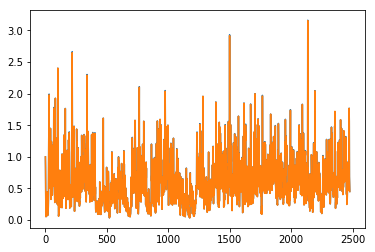

In [325]:
plt.plot(ewma_error)
plt.plot(prev_error)
plt.show()

In [326]:
print(np.mean(ewma_error))
print(np.mean(prev_error))
print(np.mean(diff_error))

0.6054195004836371
0.6019341389613849
0.006052333910731017


# Forecasting variances

In [327]:
SectorReturns.head()

,sector00,sector01,sector02,sector03,sector04,sector05,sector06,sector07,sector08,sector09,sector10,sector11
0,0.026446,0.062050,0.035061,0.026273,-0.002680,0.044343,0.003996,0.014099,0.045442,-0.005009,0.010367,0.033455
1,0.033770,0.071991,0.039359,0.035640,0.006322,0.051470,0.012559,0.012579,0.055731,0.004568,0.013099,0.038446
2,0.042929,0.062558,0.046905,0.035530,-0.000731,0.031303,0.004737,0.011450,0.047899,0.014783,0.009063,0.032372
3,0.046204,0.074940,0.046002,0.033507,0.004508,0.038635,0.011917,0.014356,0.072897,0.022898,0.016558,0.041497
4,0.032597,0.050061,0.045827,0.030412,0.010189,0.017024,0.017839,0.022747,0.070233,0.029531,0.002729,0.026880


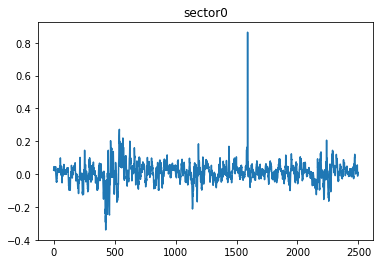

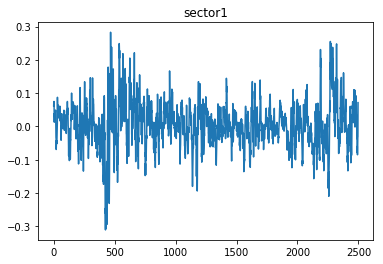

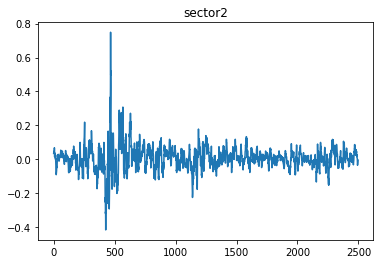

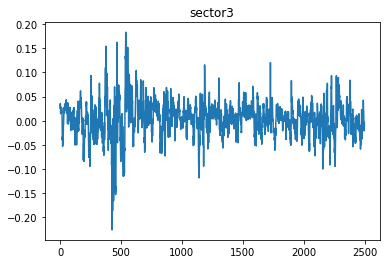

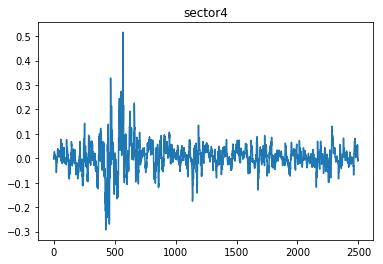

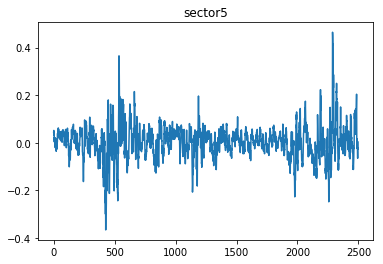

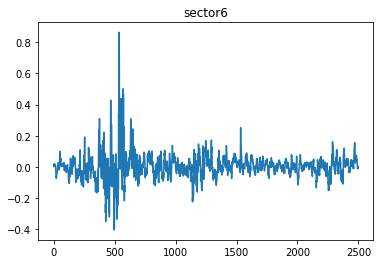

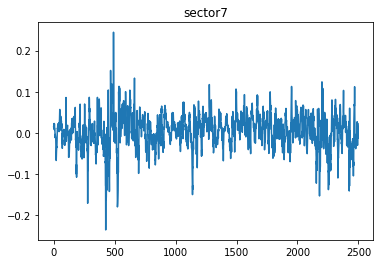

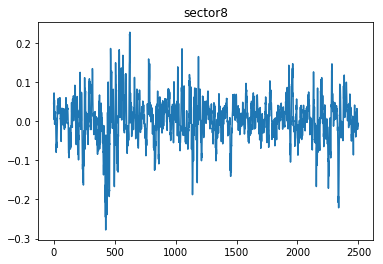

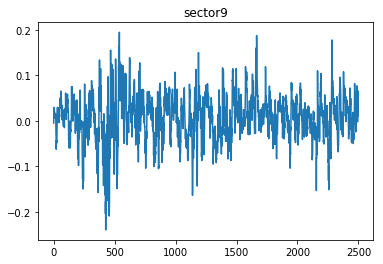

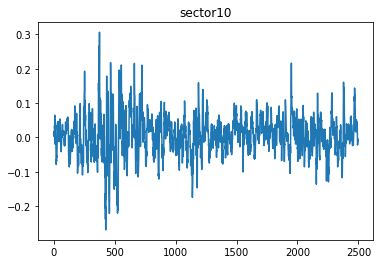

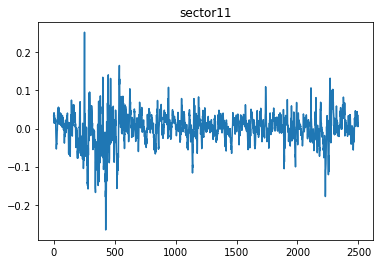

In [328]:
for i in range(num_sector):
    num_str = '0'+str(i%num_sector) if i%num_sector<10 else str(i%num_sector)
    plt.plot(SectorReturns['sector'+num_str])
    plt.title('sector'+str(i))
    plt.show()

In [329]:
VarianceRoll = SectorReturns.rolling(20).var().dropna()

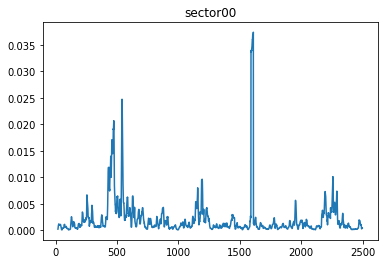

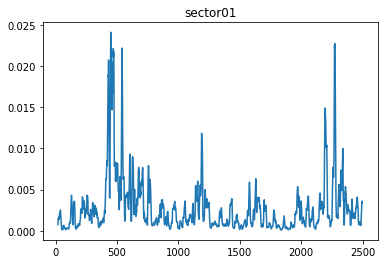

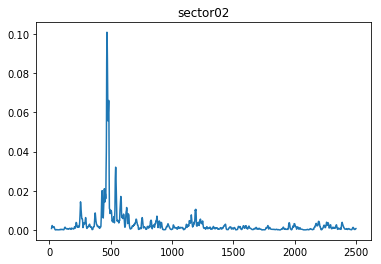

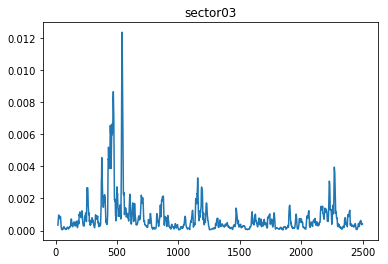

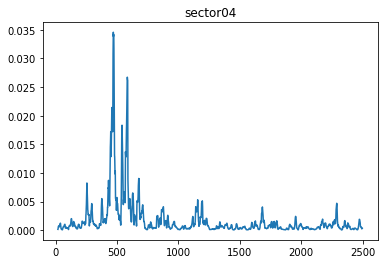

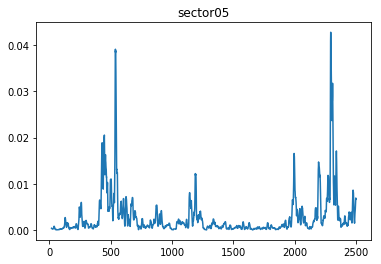

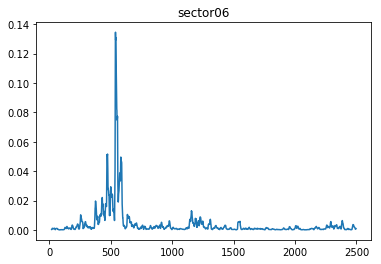

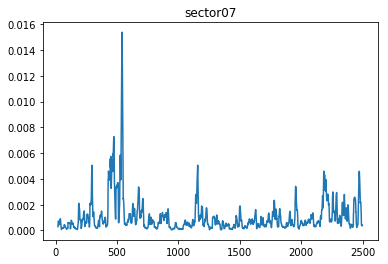

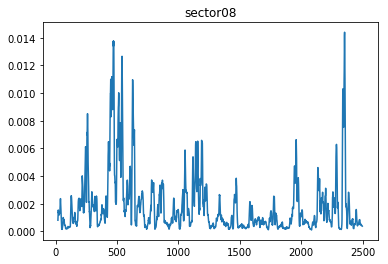

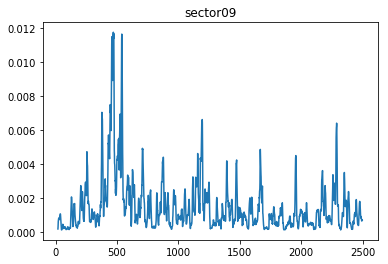

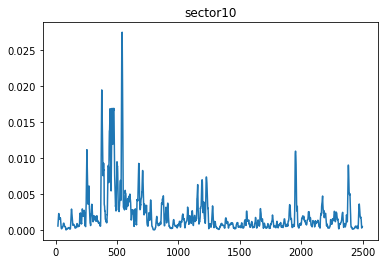

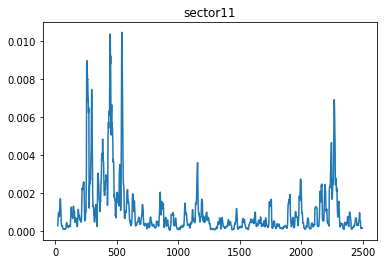

In [330]:
for i in range(num_sector):
    num_str = '0'+str(i%num_sector) if i%num_sector<10 else str(i%num_sector)
    plt.plot(VarianceRoll['sector'+num_str])
    plt.title('sector'+num_str)
    plt.show()

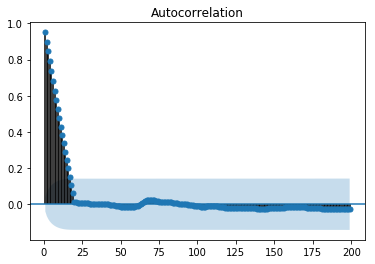

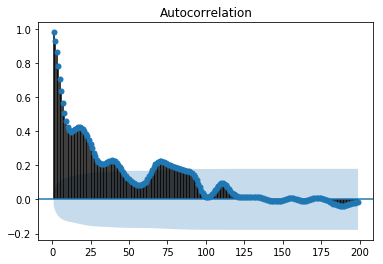

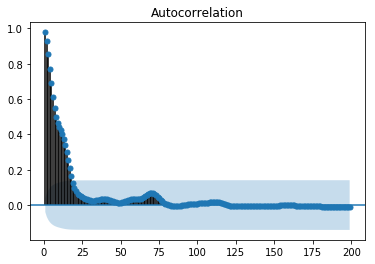

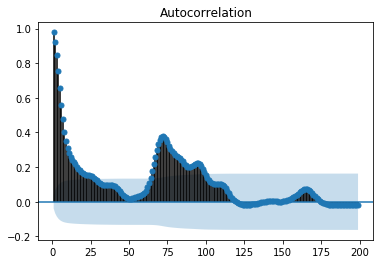

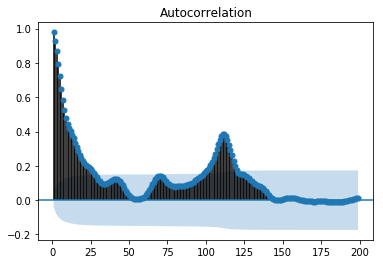

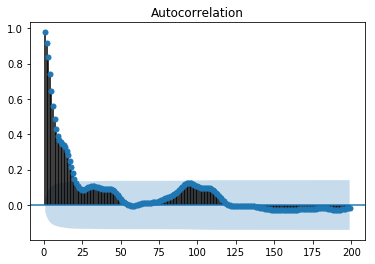

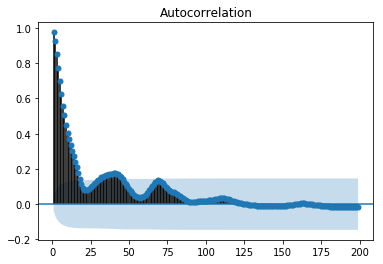

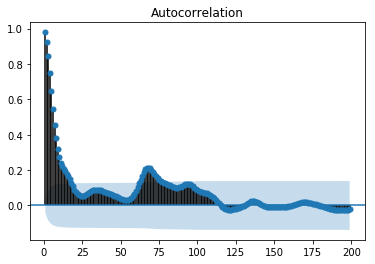

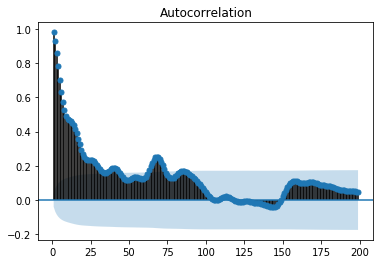

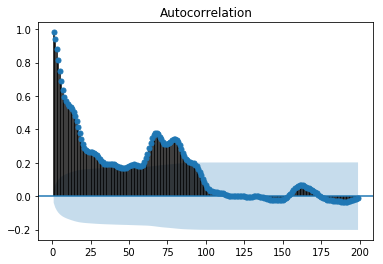

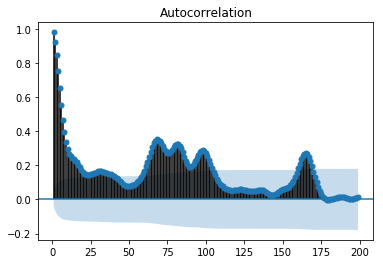

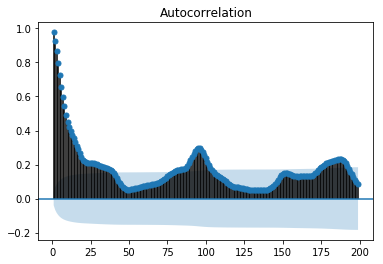

In [331]:
# ACF of squared data
for i in range(num_sector):
    num_str = '0'+str(i%num_sector) if i%num_sector<10 else str(i%num_sector)
    plot_acf(VarianceRoll['sector'+num_str]**2,lags = [i for i in range(1,200)])

In [332]:
n_test = len(VarianceRoll)//10

## Fit ARCH model

Fitting ARCH for Sector 00
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3405.38468204
Iteration:      2,   Func. Count:    109,   Neg. LLF: -3416.26661263
Iteration:      3,   Func. Count:    163,   Neg. LLF: -3480.10797357
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3480.10797757
            Iterations: 7
            Function evaluations: 163
            Gradient evaluations: 3


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


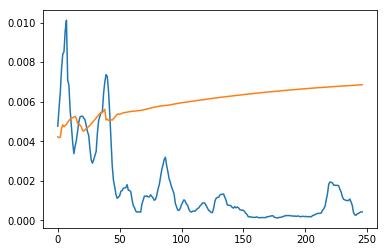

Fitting ARCH for Sector 01
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3289.2761937
Iteration:      2,   Func. Count:    110,   Neg. LLF: -3293.48877115
Iteration:      3,   Func. Count:    164,   Neg. LLF: -3374.69129993
Iteration:      4,   Func. Count:    218,   Neg. LLF: -3416.06480624
Iteration:      5,   Func. Count:    272,   Neg. LLF: -3527.1740838
Iteration:      6,   Func. Count:    326,   Neg. LLF: -3562.06033113
Iteration:      7,   Func. Count:    380,   Neg. LLF: -3608.28475857
Iteration:      8,   Func. Count:    434,   Neg. LLF: -3637.4927655
Iteration:      9,   Func. Count:    488,   Neg. LLF: -3670.7156598
Iteration:     10,   Func. Count:    542,   Neg. LLF: -3692.95955868
Iteration:     11,   Func. Count:    596,   Neg. LLF: -3716.02038477
Iteration:     12,   Func. Count:    650,   Neg. LLF: -3731.40806168
Iteration:     13,   Func. Count:    704,   Neg. LLF: -3745.87287309
Iteration:     14,   Func. Count:    758,   Neg. LLF: -3757.72970899
Iteration: 

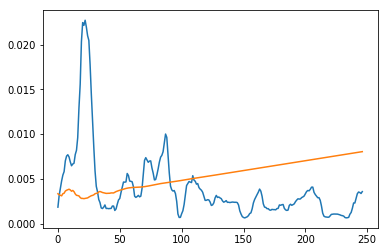

Fitting ARCH for Sector 02
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3384.71350882
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3384.71351061
            Iterations: 5
            Function evaluations: 53
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


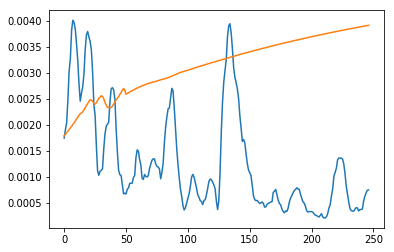

Fitting ARCH for Sector 03
Iteration:      1,   Func. Count:     53,   Neg. LLF: -4596.21243087
Iteration:      2,   Func. Count:    107,   Neg. LLF: -4698.20330222
Iteration:      3,   Func. Count:    161,   Neg. LLF: -4757.46789661
Iteration:      4,   Func. Count:    215,   Neg. LLF: -4799.64857229
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4799.64857571
            Iterations: 8
            Function evaluations: 215
            Gradient evaluations: 4


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


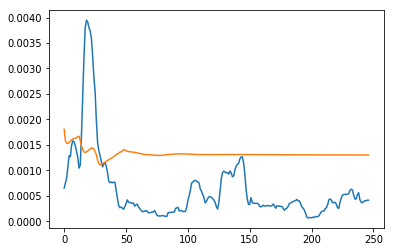

Fitting ARCH for Sector 04
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3946.13692819
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3946.13692947
            Iterations: 5
            Function evaluations: 53
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


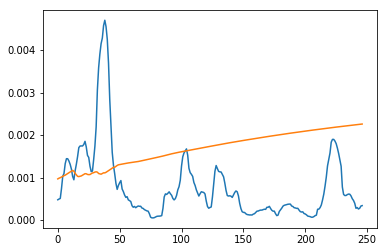

Fitting ARCH for Sector 05
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3456.51326484
Iteration:      2,   Func. Count:    107,   Neg. LLF: -3583.01642758
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3583.01643076
            Iterations: 6
            Function evaluations: 107
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


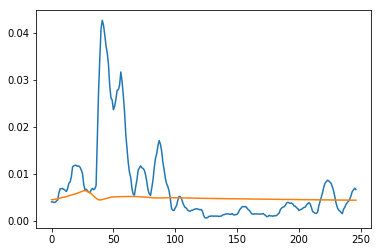

Fitting ARCH for Sector 06
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3309.03121446
Iteration:      2,   Func. Count:    107,   Neg. LLF: -3437.87172555
Iteration:      3,   Func. Count:    161,   Neg. LLF: -3512.16967871
Iteration:      4,   Func. Count:    215,   Neg. LLF: -3568.18922936
Iteration:      5,   Func. Count:    269,   Neg. LLF: -3614.48477901
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3614.48478499
            Iterations: 9
            Function evaluations: 269
            Gradient evaluations: 5


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


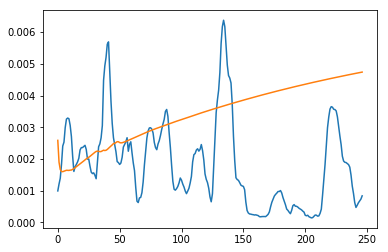

Fitting ARCH for Sector 07
Iteration:      1,   Func. Count:     53,   Neg. LLF: -4220.10542963
Iteration:      2,   Func. Count:    109,   Neg. LLF: -4227.82873406
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4227.82873698
            Iterations: 6
            Function evaluations: 109
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


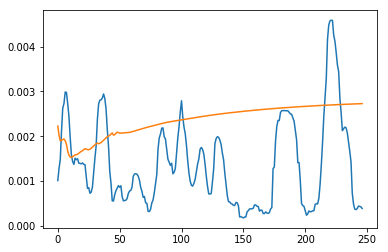

Fitting ARCH for Sector 08
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3640.91126526
Iteration:      2,   Func. Count:    110,   Neg. LLF: -3647.66900696
Iteration:      3,   Func. Count:    164,   Neg. LLF: -3719.04099344
Iteration:      4,   Func. Count:    218,   Neg. LLF: -3757.077813
Iteration:      5,   Func. Count:    272,   Neg. LLF: -4049.01608272
Iteration:      6,   Func. Count:    326,   Neg. LLF: -4083.93153934
Iteration:      7,   Func. Count:    380,   Neg. LLF: -4095.79787816
Iteration:      8,   Func. Count:    434,   Neg. LLF: -4115.91266156
Iteration:      9,   Func. Count:    488,   Neg. LLF: -4121.11397212
Iteration:     10,   Func. Count:    542,   Neg. LLF: -4123.88877014
Iteration:     11,   Func. Count:    596,   Neg. LLF: -4125.62843463
Iteration:     12,   Func. Count:    651,   Neg. LLF: -4126.61829298
Iteration:     13,   Func. Count:    706,   Neg. LLF: -4126.94103346
Iteration:     14,   Func. Count:    760,   Neg. LLF: -4128.05174489
Iteration

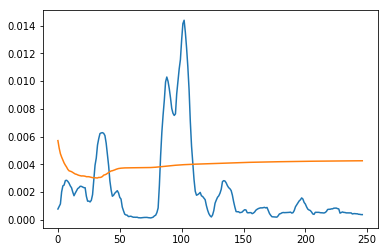

Fitting ARCH for Sector 09
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3695.28180703
Iteration:      2,   Func. Count:    107,   Neg. LLF: -3807.77416005
Iteration:      3,   Func. Count:    161,   Neg. LLF: -3876.21534295
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3876.21534686
            Iterations: 7
            Function evaluations: 161
            Gradient evaluations: 3


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


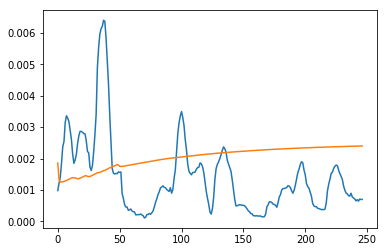

Fitting ARCH for Sector 10
Iteration:      1,   Func. Count:     53,   Neg. LLF: -3482.26310088
Iteration:      2,   Func. Count:    107,   Neg. LLF: -3596.90097123
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3596.90097395
            Iterations: 6
            Function evaluations: 107
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


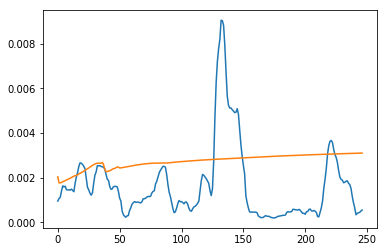

Fitting ARCH for Sector 11
Iteration:      1,   Func. Count:     53,   Neg. LLF: -4429.37740006
Iteration:      2,   Func. Count:    107,   Neg. LLF: -4613.88597472
Iteration:      3,   Func. Count:    161,   Neg. LLF: -4670.46749537
Iteration:      4,   Func. Count:    215,   Neg. LLF: -4712.87340999
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4712.87341487
            Iterations: 8
            Function evaluations: 215
            Gradient evaluations: 4


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


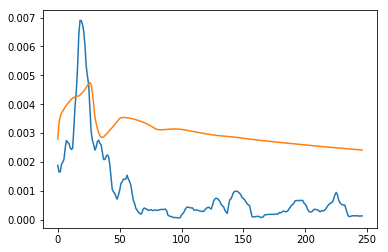

In [333]:
for i in range(num_sector):
    num_str = '0'+str(i%num_sector) if i%num_sector<10 else str(i%num_sector)
    print("Fitting ARCH for Sector "+ num_str)
    data = SectorReturns['sector'+ num_str]
    train, test = data[:-n_test], data[-n_test:]
    model = arch_model(train, mean='Zero', vol='ARCH', p=50)
    # fit model
    model_fit = model.fit()
    #print(model_fit.summary())
    # forecast the test set
    yhat = model_fit.forecast(horizon=n_test)
    # plot the actual variance
    plt.plot(VarianceRoll['sector'+ num_str][-n_test:].reset_index(drop = True))
    # plot forecast variance
    plt.plot(yhat.variance.values[-1, :])
    plt.show()

## Fit GARCH model

Fitting ARCH for Sector 00
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3293.62559493
Iteration:      2,   Func. Count:    207,   Neg. LLF: -3518.2741303
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3518.27413872
            Iterations: 6
            Function evaluations: 207
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


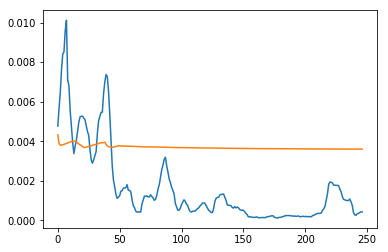

Fitting ARCH for Sector 01
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3203.86886716
Iteration:      2,   Func. Count:    207,   Neg. LLF: -3366.44535988
Iteration:      3,   Func. Count:    311,   Neg. LLF: -3455.28852114
Iteration:      4,   Func. Count:    415,   Neg. LLF: -3519.22485676
Iteration:      5,   Func. Count:    519,   Neg. LLF: -3569.81244595
Iteration:      6,   Func. Count:    623,   Neg. LLF: -3613.34787161
Iteration:      7,   Func. Count:    727,   Neg. LLF: -3652.42740557
Iteration:      8,   Func. Count:    831,   Neg. LLF: -3683.33336402
Iteration:      9,   Func. Count:    935,   Neg. LLF: -3708.45295382
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3708.45296124
            Iterations: 13
            Function evaluations: 935
            Gradient evaluations: 9


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


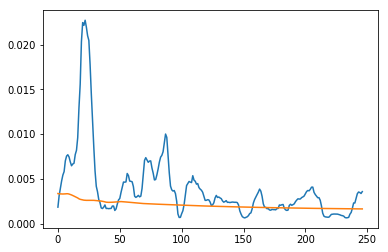

Fitting ARCH for Sector 02
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3240.0484186
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3240.04843279
            Iterations: 5
            Function evaluations: 103
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


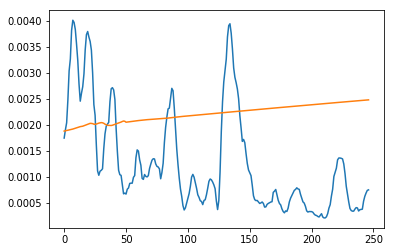

Fitting ARCH for Sector 03
Iteration:      1,   Func. Count:    103,   Neg. LLF: -4517.50345357
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4517.50346109
            Iterations: 5
            Function evaluations: 103
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


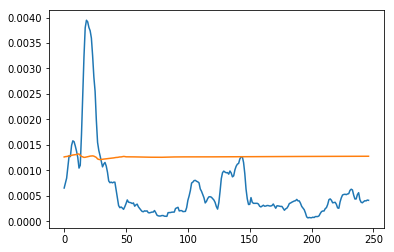

Fitting ARCH for Sector 04
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3797.92536641
Iteration:      2,   Func. Count:    207,   Neg. LLF: -4152.76206398
Iteration:      3,   Func. Count:    311,   Neg. LLF: -4197.46608041
Iteration:      4,   Func. Count:    415,   Neg. LLF: -4245.97977019
Iteration:      5,   Func. Count:    521,   Neg. LLF: -4248.34215276
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4248.34216196
            Iterations: 9
            Function evaluations: 521
            Gradient evaluations: 5


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


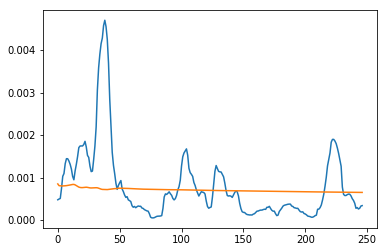

Fitting ARCH for Sector 05
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3326.79060151
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3326.79060866
            Iterations: 5
            Function evaluations: 103
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


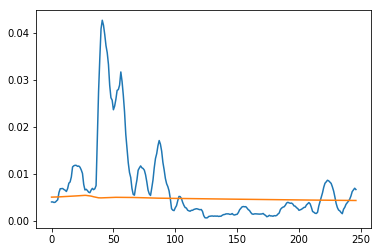

Fitting ARCH for Sector 06
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3121.23267406
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3121.23269602
            Iterations: 5
            Function evaluations: 103
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


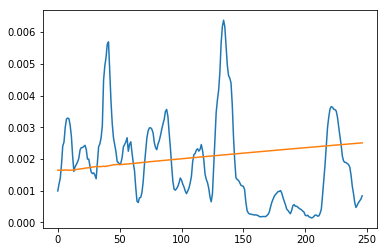

Fitting ARCH for Sector 07
Iteration:      1,   Func. Count:    103,   Neg. LLF: -4176.04319271
Iteration:      2,   Func. Count:    210,   Neg. LLF: -4178.00678456
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4178.00679076
            Iterations: 6
            Function evaluations: 210
            Gradient evaluations: 2


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


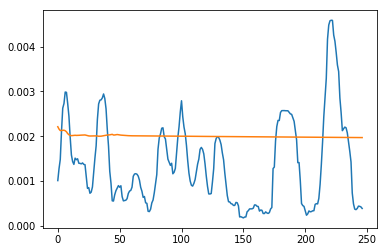

Fitting ARCH for Sector 08
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3547.27457251
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3547.27457667
            Iterations: 5
            Function evaluations: 103
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


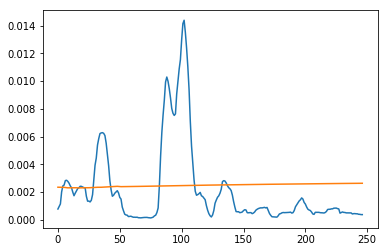

Fitting ARCH for Sector 09
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3665.72622203
Iteration:      2,   Func. Count:    207,   Neg. LLF: -3813.51061769
Iteration:      3,   Func. Count:    311,   Neg. LLF: -3881.2662375
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3881.26624779
            Iterations: 7
            Function evaluations: 311
            Gradient evaluations: 3


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


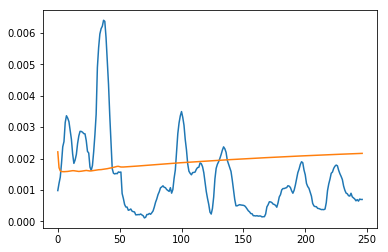

Fitting ARCH for Sector 10
Iteration:      1,   Func. Count:    103,   Neg. LLF: -3403.57882907
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -3403.57883532
            Iterations: 5
            Function evaluations: 103
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


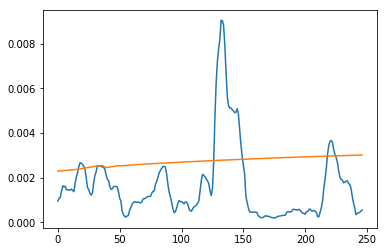

Fitting ARCH for Sector 11
Iteration:      1,   Func. Count:    103,   Neg. LLF: -4352.68166632
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4352.68167444
            Iterations: 5
            Function evaluations: 103
            Gradient evaluations: 1


C:\Users\georg\Anaconda2\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


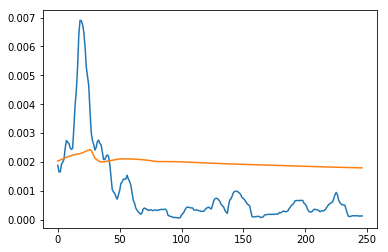

In [334]:
for i in range(num_sector):
    num_str = '0'+str(i%num_sector) if i%num_sector<10 else str(i%num_sector)
    print("Fitting ARCH for Sector "+num_str)
    data = SectorReturns['sector'+num_str]
    train, test = data[:-n_test], data[-n_test:]
    model = arch_model(train, mean='Zero', vol='GARCH', p=50,q=50)
    # fit model
    model_fit = model.fit()
    #print(model_fit.summary())
    # forecast the test set
    yhat = model_fit.forecast(horizon=n_test)
    # plot the actual variance
    plt.plot(VarianceRoll['sector'+num_str][-n_test:].reset_index(drop = True))
    # plot forecast variance
    plt.plot(yhat.variance.values[-1, :])
    plt.show()